# 1. Importing Libraries

In [21]:
#Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from preprocessing import *
from mathutils import *

import random

import struct
from array import array

%matplotlib inline

sns.set_theme(style='whitegrid')

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# 2. Loading Datasets

Loading MNIST dataset...
MNIST dataset loaded.


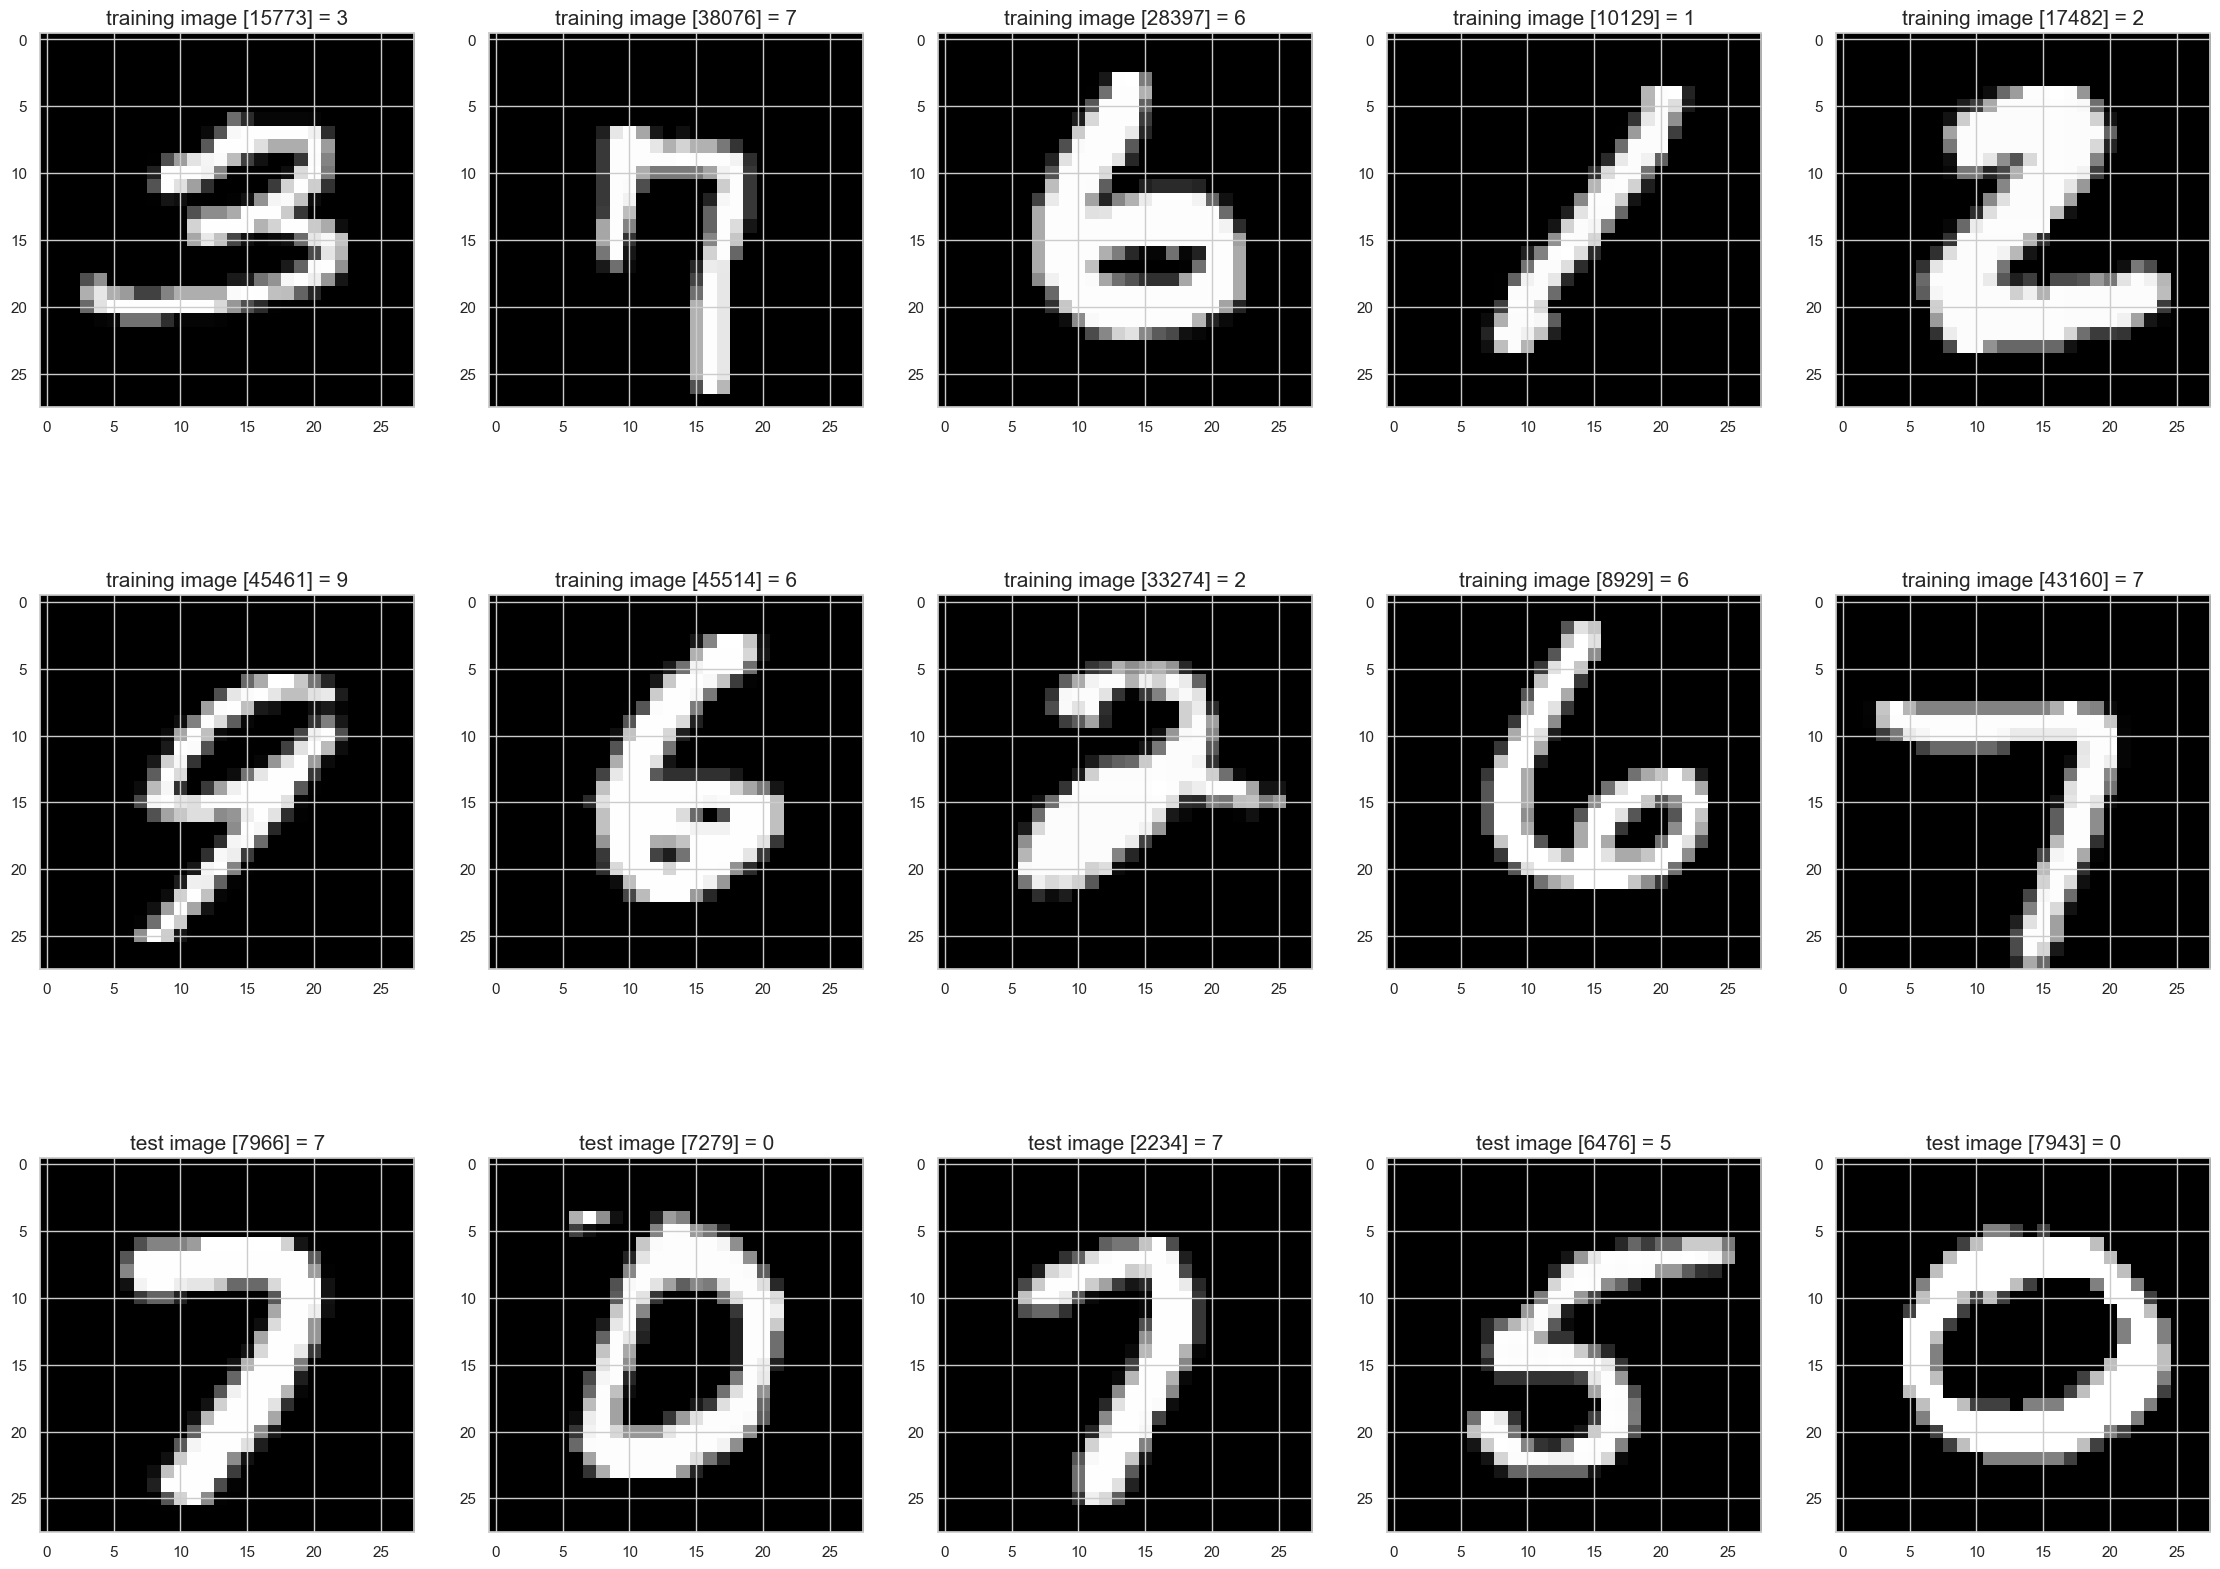

In [ ]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

# Set file paths based on added MNIST Datasets
training_images_filepath = './mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = './mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = './mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = './mnist-dataset/t10k-labels.idx1-ubyte'


# Load MINST dataset
print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')

# Show example images
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)      
        index += 1

random_images = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    random_images.append((x_train[r], 'training image [' + str(r) + '] = ' + str(y_train[r])))
for i in range(0, 5):
    r = random.randint(1, 10000)
    random_images.append((x_test[r], 'test image [' + str(r) + '] = ' + str(y_test[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

# 3. Building Neural Network's model

In [24]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute crossentropy from logits[batch,n_classes] and ids of correct answers                 
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)    
    return (- ones_for_answers + softmax) / logits.shape[0]

# A building block. Each layer is capable of performing two things:
#  - Process input to get output:           output = layer.forward(input)
#  - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
# Some layers also have learnable parameters which they update during layer.backward.
class Layer(object):
    def __init__(self):        
        pass
    
    def forward(self, input):
        # Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        # A dummy layer just returns whatever it gets as input.
        return input
    
    def backward(self, input, grad_output):
        # Performs a backpropagation step through the layer, with respect to the given input.
        # To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        # d loss / d x  = (d loss / d layer) * (d layer / d x)
        # Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        # If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly 
        num_units = input.shape[1]
        d_layer_d_input = np.eye(num_units)
        return np.dot(grad_output, d_layer_d_input) # chain rule


class ReLU(Layer):
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0, input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output * relu_grad

class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate = 0.1):
        # A dense layer is a layer which performs a learned affine transformation: f(x) = <W*x> + b
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, scale = np.sqrt(2 / (input_units + output_units)), size = (input_units, output_units))
        self.biases = np.zeros(output_units)
    
    def forward(self, input):
        # Perform an affine transformation: f(x) = <W*x> + b        
        # input shape: [batch, input_units]
        # output shape: [batch, output units]        
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, input, grad_output):
        # compute d f / d x = d f / d dense * d dense / d x where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0) * input.shape[0]
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

    
class MCP(object):
    def __init__(self):
        self.layers = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def forward(self, X):
        # Compute activations of all network layers by applying them sequentially.
        # Return a list of activations for each layer. 
        activations = []
        input = X
        
        # Looping through each layer
        for l in self.layers:
            activations.append(l.forward(input))
            # Updating input to last layer output
            input = activations[-1]
    
        assert len(activations) == len(self.layers)
        return activations
    
    
    def train_batch(self, X, y):
        # Train our network on a given batch of X and y.
        # We first need to run forward to get all layer activations.
        # Then we can run layer.backward going from last to first layer.
        # After we have called backward for all layers, all Dense layers have already made one gradient step.
        
        layer_activations = self.forward(X)
        layer_inputs = [X] + layer_activations  # layer_input[i] is an input for layer[i]
        logits = layer_activations[-1]
        
        # Compute the loss and the initial gradient    
        y_argmax =  y.argmax(axis=1)        
        loss = softmax_crossentropy_with_logits(logits, y_argmax)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y_argmax)
    
        # Propagate gradients through the network
        # Reverse propogation as this is backprop
        for layer_index in range(len(self.layers))[::-1]:
            layer = self.layers[layer_index]        
            loss_grad = layer.backward(layer_inputs[layer_index], loss_grad) # grad w.r.t. input, also weight updates
        
        return np.mean(loss)
    
    def train(self, X_train, y_train, n_epochs = 25, batch_size = 32):
        train_log = []        
        
        for epoch in range(n_epochs):        
            for i in range(0, X_train.shape[0], batch_size):
                # Get pair of (X, y) of the current minibatch/chunk
                x_batch = np.array([x.flatten() for x in X_train[i:i + batch_size]])
                y_batch = np.array([y for y in y_train[i:i + batch_size]])        
                self.train_batch(x_batch, y_batch)
    
            train_log.append(np.mean(self.predict(X_train) ==  y_train.argmax(axis=-1)))                
            print(f"Epoch: {epoch + 1}, Train accuracy: {train_log[-1]}")                        
        return train_log
    
    def predict(self, X):
        # Compute network predictions. Returning indices of largest Logit probability
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)

# 4. Training Neural Network

X_train.shape (60000, 784)
Y_train.shape (60000, 10)
Epoch: 1, Train accuracy: 0.9258666666666666
Epoch: 2, Train accuracy: 0.9486
Epoch: 3, Train accuracy: 0.9606166666666667
Epoch: 4, Train accuracy: 0.9674666666666667
Epoch: 5, Train accuracy: 0.9721166666666666
Epoch: 6, Train accuracy: 0.9758166666666667
Epoch: 7, Train accuracy: 0.9787333333333333
Epoch: 8, Train accuracy: 0.9816
Epoch: 9, Train accuracy: 0.9834833333333334
Epoch: 10, Train accuracy: 0.9851666666666666
Epoch: 11, Train accuracy: 0.9863166666666666
Epoch: 12, Train accuracy: 0.98755
Epoch: 13, Train accuracy: 0.9888833333333333
Epoch: 14, Train accuracy: 0.9896333333333334
Epoch: 15, Train accuracy: 0.9902833333333333
Epoch: 16, Train accuracy: 0.9908333333333333
Epoch: 17, Train accuracy: 0.9914166666666666
Epoch: 18, Train accuracy: 0.9919833333333333
Epoch: 19, Train accuracy: 0.9925166666666667
Epoch: 20, Train accuracy: 0.9929666666666667
Epoch: 21, Train accuracy: 0.9931833333333333
Epoch: 22, Train accuracy

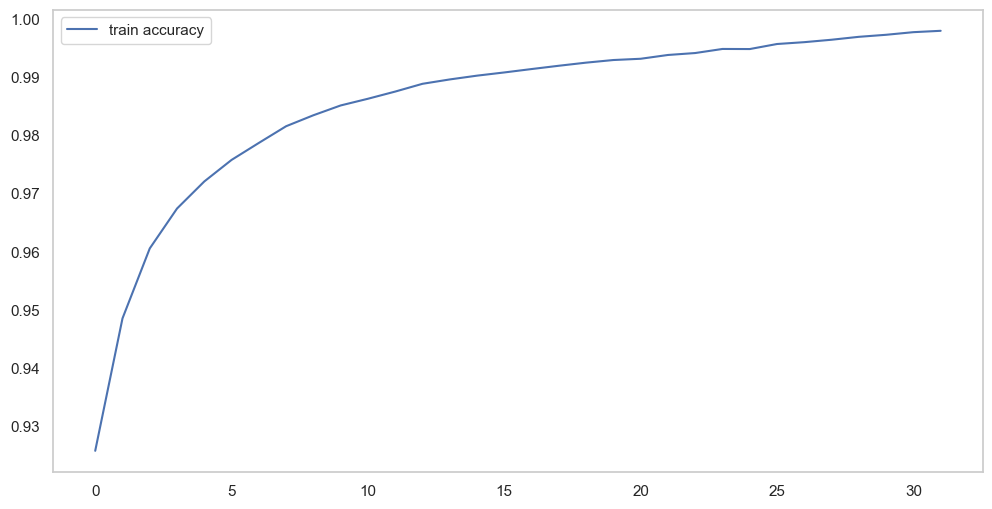

Test accuracy = 9777/10000 = 0.9777


In [28]:
def normalize(X):
    X_normalize = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_normalize   

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)]) 

X_train = normalize(np.array([np.ravel(x) for x in x_train]))
X_test = normalize(np.array([np.ravel(x) for x in x_test]))
Y_train = np.array([one_hot(np.array(y, dtype=int), 10) for y in y_train], dtype=int)
Y_test = np.array([one_hot(np.array(y, dtype=int), 10) for y in y_test], dtype=int)

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)
input_size = X_train.shape[1]
output_size = Y_train.shape[1]

network = MCP()
network.add_layer(Dense(input_size, 100, learning_rate = 0.05))
network.add_layer(ReLU())
network.add_layer(Dense(100, 200, learning_rate = 0.05))
network.add_layer(ReLU())
network.add_layer(Dense(200, output_size))

train_log = network.train(X_train, Y_train, n_epochs = 32, batch_size = 64)
plt.plot(train_log,label = 'train accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()


test_corrects = len(list(filter(lambda x: x, network.predict(X_test) ==  Y_test.argmax(axis=-1))))
test_all = len(X_test)
test_accuracy = test_corrects/test_all #np.mean(test_errors)
print(f"Test accuracy = {test_corrects}/{test_all} = {test_accuracy}")

# 5. Getting Result

In [26]:
network.predict(X_test[1:2])

array([2])

# 6. Visualizing the result 

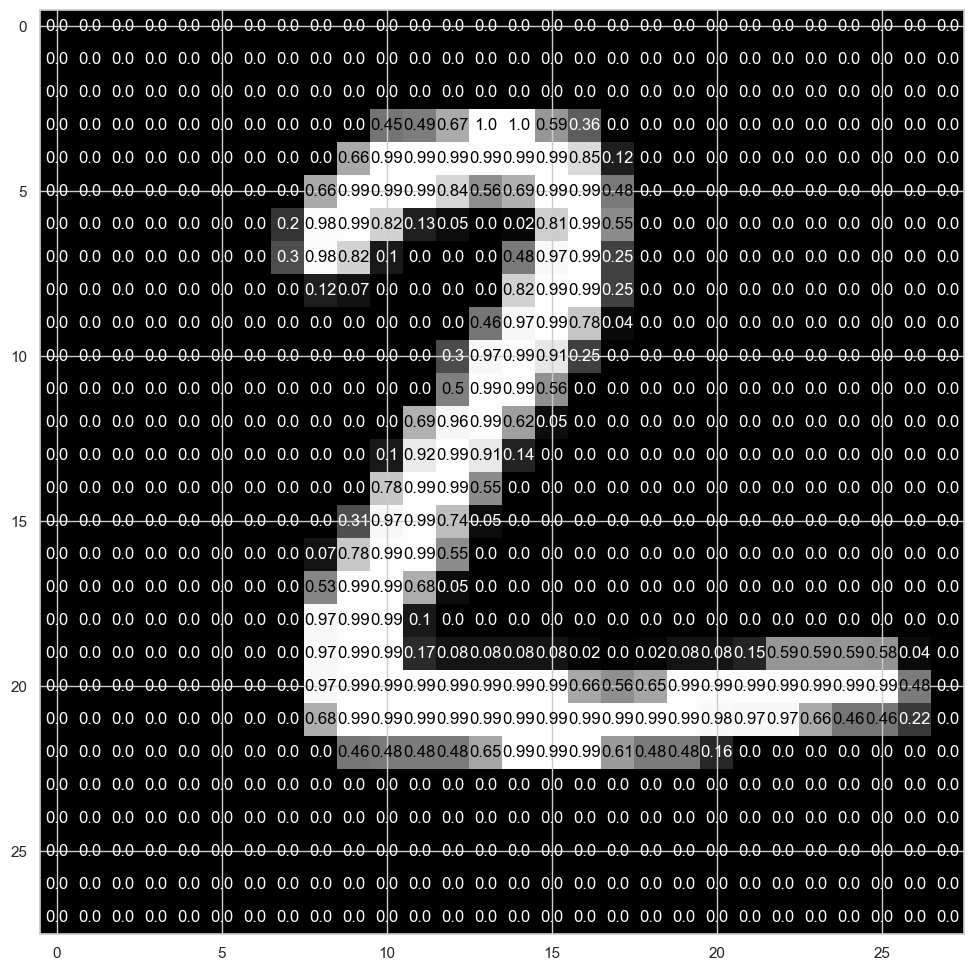

In [27]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_test[1:2].reshape(28,28), ax)